<a href="https://colab.research.google.com/github/w165mam/soii_neural_autocoder/blob/master/Introduction_to_Deep_Learning_and_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# Deep Learning and Neural Networks

Deep learning is a subfield of machine learning that seeks to solve problems by learning intermediate data representations. The primary algorithm for deep learning is the deep neural network, and if you've been following developments in Artificial Intelligence over the last decade you have probably heard a lot about them. Among its many recent accomplishments, deep learning techniques are now directly responsible the recent and very dramatic advances in image recognition, speech recognition, and language understanding.

Unfortunately, as you will soon see, deep neural networks also much more difficult to build than the models we have seen so far in class. Among the many challenges:
1. Deep neural networks often require extraordinary amounts of computation
2. Effective training of deep neural networks often relies on a wide variety of poorly understood heuristics
3. Deep neural networks tends to have a much larger number of hyperparameters requiring expert tuning

We can only partially address the first problem in this class. Specifically, BLS now has a small number of high-end GPU's (Graphical Processing Units). A GPU is basically a very cheap super-computer, optimized for linear algebra operations. Each contains several thousand simple computers with ultra-fast memory interfaces between them so they can rapidly exchange and aggregate information.

We will be using these GPU's for our experiments. If you wish to train deep neural networks outside of BLS, Google makes free GPU's available through [Google Colab](https://colab.research.google.com/). GPU's are also relatively affordable, a good buying guide for deep learning applications is available [here](https://blog.slavv.com/picking-a-gpu-for-deep-learning-3d4795c273b9). You are also free to try training neural networks without GPU acceleration, but be warned, unless you are building something very simple, you will be waiting a long time.

One consequence of the deep neural networks' exotic hardware needs is that we will also need new software capable of using that hardware. We will use the `tensorflow` library, which is the most popular tool for training deep neural networks. We will also be using the `keras` library, which is a simplified interface on top of tensorflow. A reasonable alternative is the `PyTorch` library, but we will not cover that in this class.

# What is a deep neural network?

A deep neural network is just an extension of logistic regression, which itself is just an extension of linear regression. Recall the basic equation for a simple linear regression. If the inputs are represented by the variables $x_1, x_2, ..., x_i$, and the weights controlling the influence of these inputs is represented by $w_1, w_2, ..., w_i$ then the equation for linear regression is:

$y=w_1x_1 + w_2x_2 + ... + w_ix_i$

As we saw in logistic regression, we can modify this one step further, by passing the entire output through the logistic function $f(z)=\frac{1}{1+e^{-z}}$. This has the effect of contraining the output to be between 0 and 1. Our equation now becomes:

$y=f(w_1x_1 + w_2x_2 + ... + w_ix_i)$

If we draw this in graphical form, with three inputs, it resembles the following:

![logistic regression](https://github.com/ameasure/colab_tutorials/blob/master/Images/artificial%20neuron.png?raw=1)

From this perspective, logistic regression shares some similarities with the biological neuron. Like a biological neuron, logistic regression receives inputs from a variety of sources. Like a biological neuron, the influence of these inputs seems to be controlled by the strengths of the connections (represented by weights, in logistic regression). And like a biological neuron, the logistic regression uses this information to produce an output. Hence, an alternate interpretation of logistic regression, the artificial neuron. In neural network speak, this neuron has 4 key components:
* three inputs ($x_1, x_2, x_3$)
* three weights ($w_1, w_2, w_3$)
* an acitivation function ($f(w,x)$, in this case the `logistic` function)
* an output (a.k.a. activation) ($y$)

Logistic regression does not, of course, acquire any magical new powers by simply changing its name. But interesting things start to happen as we extend our metaphor. What happens when we start connecting these artificial neurons to other artificial neurons, i.e. using the outputs of some neurons and inputs to others?

Although we can connect our neural networks in all sorts of patterns, for computational convenience it is common to organize our artificial neurons into layers, and design our neural network by describing how our various layers connect to each other.

This might sound exotic, but in fact we have already worked with a layer of artificial neurons, we just didn't know it. A single layer of artificial neurons in which each neuron is connected to all inputs and each uses the multinomial logistic function is exactly equivalent to the multinomial logistic regression we have used so extensively in this class. We will soon see however, that by connecting these layers to other layers, we can address a wide variety of issues we struggled with before. One thing that does not change however, is the fundamental process by which we calculate the weights of our artificial neural network. We still use gradient descent, specifically the following algorithm:
1. Randomly initialize the weights of our neurons to small values.
2. Choose a loss function (some measure of how poorly our model is predicting the training data)
3. Calculate the model's loss on the training data
4. Update the weights in the direction that reduces loss (using calculus)
5. Repeat steps 3 and 4 until we're happy with the network's performance


# Feed Forward Neural Network
Enough talk, lets start by building one of the simplest possible neural networks, a feed forward neural network with 1 hidden layer and 1 output layer. Visually, this resembles the following (but with more neurons in each layer).

![neural_network](https://github.com/ameasure/colab_tutorials/blob/master/Images/feed_forward_network_wikipedia_300px.png?raw=1)

# Note for Colab Users:
If you're running this in Google Colab make sure you open up the **Runtime** tab, select **Change runtime type** and select **GPU** as the hardware accelerator. This will make the following computations run much faster. You will also need to execute the following command to copy the msha data to your Colab instance.

In [ ]:
!wget --no-clobber 'https://github.com/ameasure/autocoding-class/raw/master/msha.xlsx'

File ‘msha.xlsx’ already there; not retrieving.



### Preparing the data
We'll use our MSHA data to train our first neural network. The process of preparing the training data is mostly similar to the process we used for scikit-learn, with one key difference. Unlike scikit-learn, Keras requires the outputs (the y-values) to be in matrix format where each row corresponds to a training example, each column corresponds to a part-of-body-code, and the column containing the correct code has a value of 1 and the others have a value of 0. Scikit-learn constructed this matrix for us behind the scenes automatically. We can easily perform the same operation for Keras using scikit-learn's LabelBinarizer.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

import pandas as pd

# read in the data and split it into training and validation
df = pd.read_excel('msha.xlsx')
df['ACCIDENT_YEAR'] = df['ACCIDENT_DT'].apply(lambda x: x.year)
df['ACCIDENT_YEAR'].value_counts()
df_train = df[df['ACCIDENT_YEAR'].isin([2010, 2011])].copy()
df_valid = df[df['ACCIDENT_YEAR'] == 2012].copy()
print('training rows:', len(df_train))
print('validation rows:', len(df_valid))

# create bag of words features
vectorizer = CountVectorizer()
vectorizer.fit(df_train['NARRATIVE'])
X_train = vectorizer.transform(df_train['NARRATIVE'])
X_valid = vectorizer.transform(df_valid['NARRATIVE'])

# keras only accepts a one-hot encoding of the training labels
# we do that here
label_encoder = LabelBinarizer().fit(df_train['INJ_BODY_PART'])
y_train = label_encoder.transform(df_train['INJ_BODY_PART'])
y_valid = label_encoder.transform(df_valid['INJ_BODY_PART'])
n_codes = len(label_encoder.classes_)

training rows: 18681
validation rows: 9032


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_train[0])

(18681, 11915)
(18681, 46)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0]


Define the organization of our neural network

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Concatenate
from keras.optimizers import Adam

# First, we create an input layer. This tells keras
# what the input data will look like. Specifically, that
# the input will contain the same number of columns
# as the X_train matrix (i.e. the number of features)
text_input = Input(shape=(X_train.shape[1],))
# Next, we create the first hidden layer.
# Dense means every neuron in this layer is connected to every input
# units specifies the number of artificial neurons in this layer
# activation indicates the activation function that will be used on each neuron
# (text_input) indicates that the layer uses output of the text_input layer as its input
layer1 = Dense(units=100, activation='relu')(text_input)
# Now we specify the ouput layer
# it contains one neuron for each part of body code (we want predctions for these)
# each neuron uses the softmax activation so that the outputs mimic probabilities
# Note: this is identical to a multinomial logistic regression model
output = Dense(units=n_codes, activation='softmax')(layer1)

# Finally, we tell Keras which layers are the inputs and outputs of our model
model = Model(inputs=[text_input], outputs=[output])

# We then tell Keras how we plan to fit the model
# optimizer - the algorithm used to calculate the neural network's weights
#   specifically, we use a variant of gradient descent called Adam
#   with a learning rate of .001
# loss - specifices the loss function we will use when updating weights
# metrics - specifies the validation metrics we will calculate after each epoch
optimizer = Adam(lr=.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.
W0625 16:45:41.522207 140393672824704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 16:45:41.536523 140393672824704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 16:45:41.541007 140393672824704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 16:45:41.579016 140393672824704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 16:45:41.587526 14039367

Examine the model.

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11915)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1191600   
_________________________________________________________________
dense_2 (Dense)              (None, 46)                4646      
Total params: 1,196,246
Trainable params: 1,196,246
Non-trainable params: 0
_________________________________________________________________


Now that we have specified our model, we can fit it to our data.

In [ ]:
# x - the training input to our model
# y - the training ouput for our model
# batch_size - the number of training examples we use for each gradient update
# epochs - the number of full cycles through the training data
# validation_data - the data we evaluate the model on at the end of each epoch
model.fit(x=X_train, y=y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32, epochs=5)

W0625 16:45:41.698828 140393672824704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0625 16:45:41.744944 140393672824704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 18681 samples, validate on 9032 samples
Epoch 1/5
18681/18681 [==============================] - 5s 250us/step - loss: 1.6969 - acc: 0.6220 - val_loss: 1.0284 - val_acc: 0.7542
Epoch 2/5
18681/18681 [==============================] - 3s 184us/step - loss: 0.7221 - acc: 0.8237 - val_loss: 0.8976 - val_acc: 0.7624
Epoch 3/5
18681/18681 [==============================] - 3s 184us/step - loss: 0.4399 - acc: 0.8910 - val_loss: 0.9147 - val_acc: 0.7565
Epoch 4/5
18681/18681 [==============================] - 4s 188us/step - loss: 0.2911 - acc: 0.9309 - val_loss: 0.9438 - val_acc: 0.7582
Epoch 5/5
18681/18681 [==============================] - 3s 186us/step - loss: 0.2042 - acc: 0.9539 - val_loss: 1.0058 - val_acc: 0.7471


What's going on? It's just gradient descent, the same algorithm we used to calculate the parameters of our models before. The main difference is that Keras is now showing us lots of intermediate outputs. In particular, you can see how the loss of the model changes as we grab a new batch of training examples, calculate the loss, and then update the weights. When we get to the end of each epoch you see Keras calculate the accuracy of the model on the validation data set. We do this so we know when to stop training our model, i.e. when the validation performance starts going down it's time to stop because our model is overfitting to the training data. We can plot the pattern below.

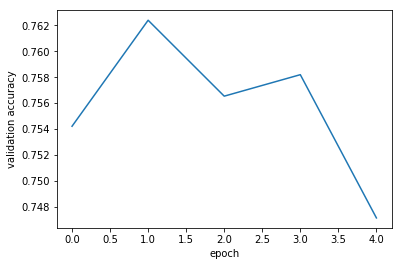

In [ ]:
from matplotlib import pyplot as plt

plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.plot(model.history.history['val_acc'])

This is a popular technique for determining how long to train neural networks because neural networks tend to be heavily over-parameterized, if you train them for long enough they can pften overfit the training data very easily.

# Using the Model
As with scikit-learn models, we can generate the predictions and save them to a dataframe.

In [ ]:
# get the [n_cases, n_classes] predicted probability matrix
prediction_prob_matrix = model.predict(X_valid)
# get the classes with the highest predicted probability, save them to our dataframe
df_valid['PREDICTED_PART'] = label_encoder.inverse_transform(prediction_prob_matrix)
# add the predicted probabilities
df_valid['PREDICTED_PROB'] = prediction_prob_matrix.max(axis=1)
# take a look at what we've got
df_valid.head()

,ACCIDENT_DT,FIPS_STATE_CD,INJ_BODY_PART,INJ_BODY_PART_CD,MINE_ID,NARRATIVE,ACCIDENT_YEAR,PREDICTED_PART,PREDICTED_PROB
2,2012-08-20,24,HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS),440,1800761,"Employee, parked s/c on grade at 16-Block #3 E...",2012,"TRUNK, MULTIPLE PARTS",0.304522
5,2012-02-21,42,BODY SYSTEMS,600,3600017,Possible heart attack.,2012,BODY SYSTEMS,0.593920
8,2012-10-03,41,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),450,3503757,Employee was cleaning up plant spillage into a...,2012,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),0.513532
12,2012-01-23,17,FINGER(S)/THUMB,340,1103189,"Employee was putting a drag on a shuttle car, ...",2012,FINGER(S)/THUMB,0.999987
27,2012-05-10,42,HAND (NOT WRIST OR FINGERS),330,4600016,While using a cutting torch to remove a bearin...,2012,HAND (NOT WRIST OR FINGERS),0.959524


# Regularization

Even more so than linear models, neural networks suffer from overfitting. Because they have such a large number of parameters they can easily memorize the data they are trained on. We can use L2-regularization, as we did with our logistic regression models, but for neural networks another popular technique is called `dropout`. In dropout we randomly set the outputs of a fraction of neurons, at each training step, to 0. A popular choice is 50%. This has a strong regularization effect that often improves overall performance. Let's try it out.

In [ ]:
text_input = Input(shape=(X_train.shape[1],))
layer1 = Dense(units=100, activation='relu')(text_input)
dropout = Dropout(0.5)(layer1)
output = Dense(units=len(label_encoder.classes_), activation='softmax')(dropout)
# specify the inputs and outputs of our model
# input is the raw text features
# output is the predicted probabilities
do_model = Model(inputs=[text_input], outputs=[output])
# specify the algorithm for calculating weights 'adam'
# specify the loss function 'categorical_crossentropy'
# specify the validation metrics we will calculate after each epoch
optimizer = Adam(lr=.001)
do_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

do_model.fit(x=X_train, y=y_train,
            validation_data=(X_valid, y_valid),
            batch_size=32, epochs=5)

W0625 16:46:01.346240 140393672824704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 18681 samples, validate on 9032 samples
Epoch 1/5
18681/18681 [==============================] - 4s 217us/step - loss: 1.9898 - acc: 0.5402 - val_loss: 1.1738 - val_acc: 0.7260
Epoch 2/5
18681/18681 [==============================] - 4s 199us/step - loss: 1.0470 - acc: 0.7481 - val_loss: 0.9203 - val_acc: 0.7679
Epoch 3/5
18681/18681 [==============================] - 4s 197us/step - loss: 0.7753 - acc: 0.8085 - val_loss: 0.8553 - val_acc: 0.7748
Epoch 4/5
18681/18681 [==============================] - 4s 200us/step - loss: 0.6129 - acc: 0.8427 - val_loss: 0.8443 - val_acc: 0.7755
Epoch 5/5
18681/18681 [==============================] - 4s 199us/step - loss: 0.5019 - acc: 0.8687 - val_loss: 0.8537 - val_acc: 0.7742


In [ ]:
prediction_prob_matrix = do_model.predict(X_valid)
df_valid['PREDICTED_PART'] = label_encoder.inverse_transform(prediction_prob_matrix)
df_valid['PREDICTED_PROB'] = prediction_prob_matrix.max(axis=1)

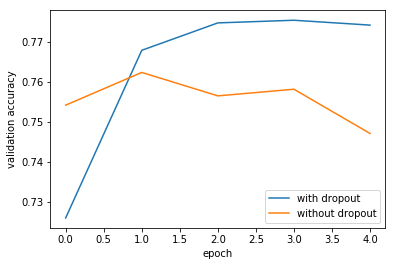

In [ ]:
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.plot(do_model.history.history['val_acc'], label='with dropout')
plt.plot(model.history.history['val_acc'], label='without dropout')
plt.legend()

As you can see, adding dropout improved the overall performance of our model and decreased overfitting.

# Uncertainty Estimates and "Bayesian Neural Networks"
We have already seen that our model's probability scores give us one useful measure of uncertainty, but there is an important caveat. The model's probability scores only reflect uncertainty observed in the training data, not uncertainty that we have learned the appropriate model. This uncertainty might seem unmeasurable, but in fact it is, and [Yarin Gal and collaborators](https://arxiv.org/pdf/1506.02142.pdf) have shown that by training a neural network model with dropout we have incidentally implemented a popular Bayesian technique for doing exactly this. To get uncertainty estimates all we need to do is leave dropout enabled during prediction and generate multiple predictions for each observation. The distribution of the resulting predictions gives us an estimate of the uncertainty associated with our model. We illustrate this below:

In [ ]:
import keras
import numpy as np


# create a dropout layer that stays on even during prediction
class MCDropout(keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

# create a dropout model that keeps dropout on
mc_text_input = Input(shape=(X_train.shape[1],))
mc_layer1 = Dense(units=100, activation='relu')(mc_text_input)
mc_dropout = MCDropout(0.5)(mc_layer1)
mc_output = Dense(units=len(label_encoder.classes_), activation='softmax')(mc_dropout)
mc_model = Model(inputs=[mc_text_input], outputs=[mc_output])
optimizer = Adam(lr=.001)
mc_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

mc_model.fit(x=X_train, y=y_train,
             validation_data=(X_valid, y_valid),
             batch_size=32, epochs=5)

Train on 18681 samples, validate on 9032 samples
Epoch 1/5
18681/18681 [==============================] - 4s 213us/step - loss: 1.9910 - acc: 0.5427 - val_loss: 1.3067 - val_acc: 0.6933
Epoch 2/5
18681/18681 [==============================] - 4s 196us/step - loss: 1.0552 - acc: 0.7461 - val_loss: 1.0515 - val_acc: 0.7411
Epoch 3/5
18681/18681 [==============================] - 4s 198us/step - loss: 0.7746 - acc: 0.8093 - val_loss: 0.9797 - val_acc: 0.7496
Epoch 4/5
18681/18681 [==============================] - 4s 199us/step - loss: 0.6105 - acc: 0.8443 - val_loss: 0.9953 - val_acc: 0.7463
Epoch 5/5
18681/18681 [==============================] - 4s 196us/step - loss: 0.5027 - acc: 0.8688 - val_loss: 1.0162 - val_acc: 0.7446


In [ ]:
# sample predictions from our model [n_pred, n_obs, n_codes]
y_probas = np.stack([mc_model.predict(X_valid) for sample in range(100)])
# recover the "best predictions" by averaging over the predicted probabilities
y_prob = y_probas.mean(axis=0)
# we can also recover the standard deviations
y_std = y_probas.std(axis=0)

Below, we visualize the probability distributions for random narratives in our validation data.atives.

Employee reported that when he was stepping out of young buggy, he turned to walk away & twisted his ankle when he stepped on a rock. He thought he was ok until later in day (5:15pm) he noticed his ankle was swollen. We took him to medic, then to ER. Doctor issued restrictions.
PREDICTED: ANKLE
CORRECT: ANKLE
PROB: 0.9936971
STD: 0.014043883


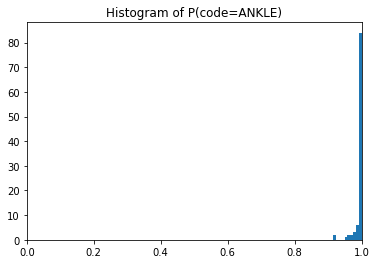

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random

# grab a random narrative in our validation set
obs_index = random.randint(0, len(df_valid))
# display the narrative
print(df_valid.iloc[obs_index]['NARRATIVE'])
# get the predicted code (the highest probability code as averaged over our samples)
pred_code = label_encoder.inverse_transform(y_prob)[obs_index]
print('PREDICTED:', pred_code)
# get the correct code
print('CORRECT:', df_valid.iloc[obs_index]['INJ_BODY_PART'])
code_index = y_prob.argmax(axis=1)[obs_index]
# display the mean probability associated with that code
print('PROB:', y_prob[obs_index][code_index])
# display the standard deviation associated with our sample probabilities
print('STD:', y_std[obs_index][code_index])
# create a histogram of the sampled probabilities for this code
n, bins, patches = plt.hist(y_probas[:, obs_index, code_index])
plt.xlim(0,1)
txt = plt.title(f'Histogram of P(code={pred_code})')

In [ ]:
# get the standard deviation just for the predicted code
y_pred_std = y_std[range(len(y_prob)), y_prob.argmax(axis=1)]

In [ ]:
df_valid['BAYES_PRED'] = label_encoder.inverse_transform(y_prob)
df_valid['BAYES_PROB'] = y_prob.max(axis=1)
df_valid['BAYES_STD'] = np.round(y_pred_std, 2)
df_valid[['NARRATIVE', 'PREDICTED_PART', 'PREDICTED_PROB',
          'BAYES_PRED', 'BAYES_PROB', 'BAYES_STD']].sample(10)

,NARRATIVE,PREDICTED_PART,PREDICTED_PROB,BAYES_PRED,BAYES_PROB,BAYES_STD
15196,EE was taking back cover off engine compartmen...,FINGER(S)/THUMB,0.991273,FINGER(S)/THUMB,0.982416,0.02
37651,Diagnosed with Noise Induced Hearing Loss of 0...,EAR(S) INTERNAL & HEARING,0.999574,EAR(S) INTERNAL & HEARING,0.993225,0.01
12628,The miner was performing the routine task of c...,KNEE/PATELLA,0.993153,KNEE/PATELLA,0.958642,0.06
13177,"Employee was pulling a water hose, and slipped...",BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0.326105,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0.375066,0.16
15209,Employee was cutting a rock dust bag when the ...,HAND (NOT WRIST OR FINGERS),0.576142,HAND (NOT WRIST OR FINGERS),0.516808,0.27
33895,The employee was doing the walk around inspect...,ANKLE,0.700591,ANKLE,0.708067,0.17
38077,"While changing cat tracks on the Bobcat, he wa...",FINGER(S)/THUMB,0.999996,FINGER(S)/THUMB,0.999933,0.00
17737,Received a CWP claim for employee on 4/10/2012,CHEST (RIBS/BREAST BONE/CHEST ORGNS),0.692692,CHEST (RIBS/BREAST BONE/CHEST ORGNS),0.699599,0.15
21344,EE at job site watching turbine pump. EE felt ...,BODY SYSTEMS,0.995118,BODY SYSTEMS,0.988378,0.02
19492,The Blast Crew was preparing for a development...,WRIST,0.993229,WRIST,0.977233,0.09


# When and why do deep neural networks work?
It's still a mystery, but hints are starting to emerge. For example, [[1]](https://arxiv.org/pdf/1608.08225.pdf) points out that hierarchical and compositional relationships are very common in nature and deep neural networks can represent these relationships with exponentially fewer parameters than shallow networks (linear models). It can also be shown that neural networks are universal function approximators, in other words they can approximate any relationship between inputs and outputs to any degree of precision.

In general, deep neural networks seem to work best on tasks where the input contains large amounts of extraneous noise, such as image and speech understanding (not math or logic).

# Next Lesson

[Convolutional Neural Networks](https://colab.research.google.com/drive/1Bck3x0znv61uDSkZIT5pAdO_oyWaUPup)